In [14]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.jupyter import *
provider = IBMQ.load_account()

# import basic plot tools
from qiskit.visualization import plot_histogram

ibmqfactory.load_account:WARNING:2023-06-26 02:09:58,145: Credentials are already in use. The existing account in the session will be replaced.


In [15]:
def initialize(circuit, n, m):
    circuit.h(range(n)) # Hadamard transform on measurment register
    circuit.x(n+m-1) # X gate on last qubit

In [16]:
def c_amod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13") # remember that a needs to be co-prime with N
    unitary = QuantumCircuit(4)        
    for iteration in range(x):
        # bitwise arithmetic to represent modular exponentiation function
        if a in [2,13]:
            unitary.swap(0,1)
            unitary.swap(1,2)
            unitary.swap(2,3)
        if a in [7,8]:
            unitary.swap(2,3)
            unitary.swap(1,2)
            unitary.swap(0,1)
        if a == 11:
            unitary.swap(1,3)
            unitary.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                unitary.x(q)
    unitary = unitary.to_gate()
    unitary.name = "%i^%i mod 15" % (a, x)
    # But we need to make it a controlled operation for phase kickback
    c_unitary = unitary.control()
    return c_unitary

In [17]:
def modular_exponentiation(circuit, n, m, a):
    for exp in range(n):
        exponent = 2**exp
        circuit.append(a_x_mod15(a, exponent), [exp] + list(range(n, n+m)))

In [18]:
from qiskit.circuit.library import QFT

In [19]:
def apply_iqft(circuit, measurement_qubits):
    circuit.append(QFT( len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)

In [20]:
def shor_algo(n, m, a):
    
    # set up the circuit
    circ = QuantumCircuit(n+m, n)
    
    # initialize the registers
    initialize(circ, n, m)
    circ.barrier()

    # map modular exponentiation problem onto qubits
    modular_exponentiation(circ, n, m, a)
    circ.barrier()

    # apply inverse QFT -- expose period
    apply_iqft(circ, range(n))

    # measure the measurement register
    circ.measure(range(n), range(n))
    
    return circ


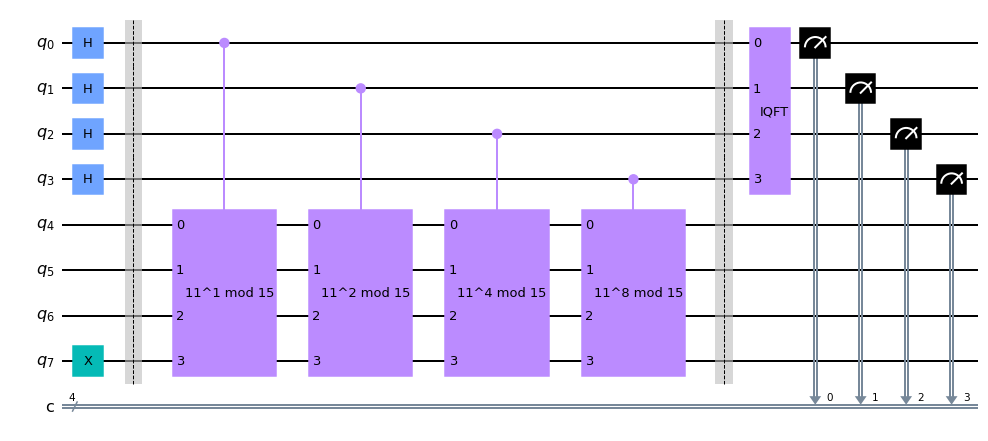

In [26]:
n = 4; m = 4; a = 11
mycircuit = shor_algo(n, m, a)
mycircuit.draw('mpl')

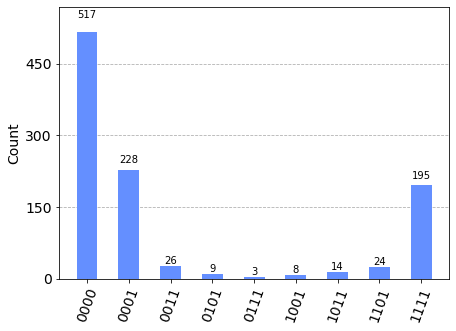

In [27]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1024).result().get_counts(mycircuit)
plot_histogram(counts)

In [28]:
for measured_value in counts:
    print(f"Measured {int(measured_value[::-1], 2)}")

Measured 15
Measured 0
Measured 9
Measured 8
Measured 12
Measured 10
Measured 13
Measured 11
Measured 14


In [29]:
from math import gcd
from math import sqrt
from itertools import count, islice

for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Measured {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Failed. Measured value is not an even number")
        continue
    x = int((a ** (measured_value_decimal/2)) % 15)
    if (x + 1) % 15 == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    print(guesses)

Measured 15
Failed. Measured value is not an even number
Measured 0
(1, 15)
Measured 9
Failed. Measured value is not an even number
Measured 8
(1, 15)
Measured 12
(1, 15)
Measured 10
(3, 5)
Measured 13
Failed. Measured value is not an even number
Measured 11
Failed. Measured value is not an even number
Measured 14
(3, 5)


In [30]:
def is_prime(n):
    return n > 1 and all(n % i for i in islice(count(2), int(sqrt(n)-1)))
if is_prime(guesses[0]) and is_prime(guesses[1]):
    print(f"**The prime factors are {guesses[0]} and {guesses[1]}**")

**The prime factors are 3 and 5**
